In [237]:
import numpy as np
import sys
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import corner

from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler

import sys, platform, os
from numpy import sqrt, sin, cos, pi
import scipy.constants as cst

camb_path = os.path.realpath(os.path.join(os.getcwd(),'..'))
sys.path.insert(0,camb_path)
import camb
from camb import model, initialpower

In [238]:
import scipy.integrate as integrate
import scipy.special as special     
from scipy.interpolate import CubicSpline
from scipy import interpolate
from scipy.optimize import curve_fit
from scipy.integrate import quad, dblquad

In [239]:
train_params = np.load('LHS_params_3dim.npz')                   # dictionary of np.arrays, 'dict' key for each of the np.arrays

In [240]:
print(train_params.files)                                       # Each of the keys has an 'np.array' of values

['h', 'omega_b', 'omega_cdm']


In [241]:
#print(train_params['omega_b'])

n_samples = len(train_params['h'])
print('number of training samples: ', len(train_params['omega_b'])) 

number of training samples:  500


In [242]:
#np.set_printoptions(threshold=sys.maxsize)
#print(train_params['h'])

In [243]:
model_params = ['h', 
                    'omega_b', 
                    'omega_cdm', 
                    ]

type(model_params)

list

In [244]:
cosmo_params = np.zeros((len(train_params['omega_b']), 3))
print(cosmo_params[199])

cosmo_params[:, 0] = train_params['h']
cosmo_params[:, 1] = train_params['omega_b']
cosmo_params[:, 2] = train_params['omega_cdm']
#cosmo_params[:, 3] = train_params['ns']
#cosmo_params[:, 4] = train_params['z']
#cosmo_params[:, 5] = train_params['lnAs']
#cosmo_params[:, 6] = train_params['w']

[0. 0. 0.]


In [245]:
print(cosmo_params[0])
print(cosmo_params[199])

[0.55911824 0.01524048 0.22915832]
[0.59418838 0.01676353 0.08406814]


In [246]:
#kh = []
#pk= []

def camb_cosmo(i):
    
    pars = camb.CAMBparams()
    pars.set_cosmology(H0=100*cosmo_params[i, 0], ombh2=cosmo_params[i, 1], omch2=cosmo_params[i, 2])
    pars.InitPower.set_params(As = 2e-9, ns=0.965)
    pars.set_matter_power(redshifts=[0.0], kmax=10.0)
    pars.set_dark_energy(w=-1.0, wa=0, dark_energy_model='fluid')

    # Linear spectra
    pars.NonLinear = model.NonLinear_none
    results = camb.get_results(pars)
    camb_kh, z, camb_pk = results.get_matter_power_spectrum(minkh=1e-4, maxkh=15, npoints=100)
    s8 = np.array(results.get_sigma8())      
    # s8 is the amplitude of matter fluctuations, i.e. in term of the average r.m.s fluctuation in a sphere of 8h^{−1}Mpc
    
    #kh.append(camb_kh)
    #pk.append(camb_pk)
    
#     plt.figure(figsize = (10,8))
#     plt.loglog(camb_kh, camb_pk[0], 'r')
#     #plt.plot(, r_array, 'ro')
#     plt.title('Matter Power Spectrum at z=0.0')
#     plt.rc('axes', labelsize=18)
#     plt.rc('axes', titlesize=16)
#     plt.rcParams['xtick.labelsize']=14
#     plt.rcParams['ytick.labelsize']=14
#     plt.xlabel(r'$k\,[h\,\mathrm{Mpc}^{-1}]$')
#     plt.ylabel(r'$\mathrm{P}(k)\, [(h^{-1}\mathrm{Mpc})^{3}]$')
#     #plt.legend(['linear'], loc='lower left', fontsize=14);
#     plt.grid(alpha=0.2)
#     plt.tick_params(top=True,right=True, length=6)
#     plt.show()
    
    return camb_kh, camb_pk[0] 
    
    
cosmo_func = camb_cosmo(0)                                                   #calculates the m.p.s of 1st sample out of 200
#print(cosmo_func[1])
#print(pk[0])

Epoch 1/100
4/4 - 0s - loss: 1.1071 - 270ms/epoch - 68ms/step
Epoch 2/100
4/4 - 0s - loss: 1.1035 - 6ms/epoch - 1ms/step
Epoch 3/100
4/4 - 0s - loss: 1.0994 - 10ms/epoch - 2ms/step
Epoch 4/100
4/4 - 0s - loss: 1.0955 - 8ms/epoch - 2ms/step
Epoch 5/100
4/4 - 0s - loss: 1.0913 - 9ms/epoch - 2ms/step
Epoch 6/100
4/4 - 0s - loss: 1.0856 - 6ms/epoch - 1ms/step
Epoch 7/100
4/4 - 0s - loss: 1.0793 - 7ms/epoch - 2ms/step
Epoch 8/100
4/4 - 0s - loss: 1.0717 - 8ms/epoch - 2ms/step
Epoch 9/100
4/4 - 0s - loss: 1.0623 - 8ms/epoch - 2ms/step
Epoch 10/100
4/4 - 0s - loss: 1.0523 - 8ms/epoch - 2ms/step
Epoch 11/100
4/4 - 0s - loss: 1.0379 - 7ms/epoch - 2ms/step
Epoch 12/100
4/4 - 0s - loss: 1.0225 - 7ms/epoch - 2ms/step
Epoch 13/100
4/4 - 0s - loss: 1.0089 - 7ms/epoch - 2ms/step
Epoch 14/100
4/4 - 0s - loss: 0.9869 - 6ms/epoch - 1ms/step
Epoch 15/100
4/4 - 0s - loss: 0.9686 - 7ms/epoch - 2ms/step
Epoch 16/100
4/4 - 0s - loss: 0.9443 - 7ms/epoch - 2ms/step
Epoch 17/100
4/4 - 0s - loss: 0.9190 - 5ms/ep

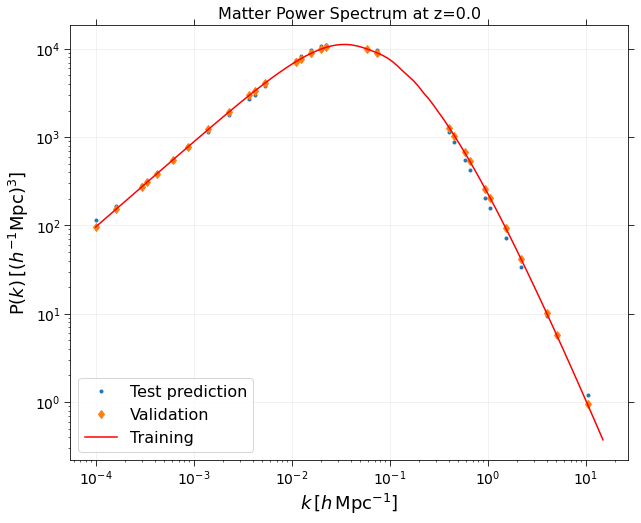

In [247]:
#TESTING (ANN for computing many cosmologies (for n_samples)):

# Generate power spectra:
cosmo_func = camb_cosmo(0)
    
train_k = cosmo_func[0]                                                             
train_pk = cosmo_func[1]    

# Standardising:

train_k_scaler = StandardScaler()
train_pk_scaler = StandardScaler()

# Storing the fit object for later reference
scaled_train_k = train_k_scaler.fit(np.log(train_k).reshape(-1,1)) 
scaled_train_pk = train_pk_scaler.fit(np.log(train_pk).reshape(-1,1))

# Generating the standardized values of X and y
X=scaled_train_k.transform(np.log(train_k).reshape(-1,1))
y=scaled_train_pk.transform(np.log(train_pk).reshape(-1,1))

# Split the data into training and testing set


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42) 

# initializing the internal random number generator, setting random_state a fixed value will guarantee that
# same sequence of random numbers are generated each time you run the code.

# sort in ascending order:

zipped_lists = zip(X_train, y_train)
sorted_pairs = sorted(zipped_lists)

tuples = zip(*sorted_pairs)
X_train, y_train = [list(tuple) for tuple in  tuples]

X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

#Building the NN:

tf_model = Sequential()
# Defining the first layer of the model
tf_model.add(Dense(units=32, input_dim=X_train.shape[1], kernel_initializer='normal', activation='relu'))
 
# Defining the Second layer of the model
tf_model.add(Dense(units=32, kernel_initializer='normal', activation='relu'))
 
# The output neuron is a single fully connected node 
# Since we will be predicting a single number
tf_model.add(Dense(1, kernel_initializer='normal'))
 
# Compiling the model
tf_model.compile(loss='mean_squared_error', optimizer='adam')
 
# Fitting the ANN to the Training set
tf_model.fit(X_train, y_train, batch_size = 20, epochs = 100, verbose=2)
            
# Mean absolute percentage error
MAPE = np.mean(np.abs((y_test - tf_model.predict(X_test))/y_test))*100
# printing the results of the current iteration
#print(TrialNumber, 'Parameters:','batch_size:', batch_size_trial,'-', 'epochs:',epochs_trial, 'Accuracy:', 100-MAPE)
print('Accuracy:', 100-MAPE)


# Scaling the X data back to original scale
temp = X_train
temp2 = X_test

y_train_pred = scaled_train_pk.inverse_transform(tf_model.predict(temp))
y_test_pred = scaled_train_pk.inverse_transform(tf_model.predict(temp2))

X_train = scaled_train_k.inverse_transform(X_train)
X_test = scaled_train_k.inverse_transform(X_test)

# Scaling the y_test/train Price data back to original scale
y_train = scaled_train_pk.inverse_transform(y_train)
y_test = scaled_train_pk.inverse_transform(y_test)
    
# Scaling the test data back to original scale
#Test_Data = scaled_train_k.inverse_transform(X_test)

#Return to log scale:
X_train = np.exp(X_train)
y_train = np.exp(y_train)
X_test = np.exp(X_test)
y_test = np.exp(y_test)
prediction_train = np.exp(y_train_pred)
prediction_test = np.exp(y_test_pred)

plt.figure(figsize = (10,8))                                             ###DONE!
plt.loglog(X_test, prediction_test, "C0.")         #blue line
plt.loglog(X_test, y_test, "C1d")
plt.loglog(train_k, train_pk, 'r')
plt.title('Matter Power Spectrum at z=0.0')
plt.rc('axes', labelsize=18)
plt.rc('axes', titlesize=16)
plt.rcParams['xtick.labelsize']=14
plt.rcParams['ytick.labelsize']=14
plt.xlabel(r'$k\,[h\,\mathrm{Mpc}^{-1}]$')
plt.ylabel(r'$\mathrm{P}(k)\, [(h^{-1}\mathrm{Mpc})^{3}]$')
plt.legend(['Test prediction','Validation', 'Training'], loc='lower left', fontsize=16);
plt.grid(alpha=0.2)
plt.tick_params(top=True,right=True, length=6)
plt.show()

In [248]:
len(train_params['h'])

500

In [249]:
## Training input params:
h = cosmo_params[:, 0]
# ombh2:
omega_b = cosmo_params[:, 1]
# omch2:
omega_c = cosmo_params[:, 2]

#Obtain pk matrix for output training param:
pk_matrix = []                                    #np.zeros((len(train_params['h']), np.shape(train_params)[0])) 
#print(pk_matrix[199][2])

for i in range(len(train_params['h'])):
               cosmo_func = camb_cosmo(i)
               pk_matrix.append(cosmo_func[1])

In [250]:
# np.shape(pk_matrix)                          #500x100: 500 cosmologies/n_samples, each with 100 pts/elements in array
# print(pk_matrix[199])

In [251]:
# Training input params and output param:

train_H0 = 100*h                               #1x100                     # np.arrays, sizes len(train_params['h'])
train_omega_b = omega_b                        #1x100
train_omega_c = omega_c                        #1x100
train_pk = pk_matrix                           #100x500                   # don't need kh, stays the same

In [252]:
input_params = np.vstack([train_H0, train_omega_b, train_omega_c])        # n_samples = no. of rows

input_params_transpose = np.transpose(input_params)
print(np.shape(input_params_transpose))
print(np.shape(train_pk))

input_data = pd.DataFrame(input_params_transpose)
input_data.columns = ['H0', 'Omega_b', 'Omega_cdm']

output_data = pd.DataFrame(train_pk)                                       
print( input_data)                                                         #500x3
#print(output_data)

(500, 3)
(500, 100)
            H0   Omega_b  Omega_cdm
0    55.911824  0.015240   0.229158
1    69.739479  0.034519   0.234770
2    72.745491  0.026743   0.120541
3    55.110220  0.034158   0.132966
4    87.474950  0.031273   0.216733
..         ...       ...        ...
495  81.362725  0.025902   0.116934
496  66.733467  0.019289   0.223948
497  61.222445  0.022896   0.058818
498  67.234469  0.031232   0.154208
499  69.138277  0.022535   0.189880

[500 rows x 3 columns]


In [253]:
# Storing the fit object for later reference

# Split the data into training and testing sets:
X_train, X_test, y_train, y_test = train_test_split(input_data, output_data, test_size=0.3, random_state=42)
print(np.shape(X_train))    # 350x3
print(X_train.shape[1])     # 3

(350, 3)
3


In [254]:
print(X_train)

            H0   Omega_b  Omega_cdm
5    90.781563  0.028948   0.217535
116  80.060120  0.032796   0.232365
45   59.919840  0.025261   0.076052
16   99.899800  0.024820   0.182665
462  70.741483  0.034760   0.110120
..         ...       ...        ...
106  98.797595  0.032555   0.187876
270  68.336673  0.019609   0.127756
348  63.126253  0.022174   0.215531
435  59.519038  0.033397   0.141383
102  76.152305  0.023136   0.188277

[350 rows x 3 columns]


In [255]:
# Standardising:

train_input_data = StandardScaler()
test_input_data = StandardScaler()

scaled_X_train = train_input_data.fit(X_train)
scaled_X_test = test_input_data.fit(X_test)

# Generating the standardized values of X_train, X_test:
X_train1 = scaled_X_train.transform(X_train)
X_test1 = scaled_X_test.transform(X_test)

In [256]:
print("y_test shape:", np.shape(y_test))
print("X_train1 shape:", np.shape(X_train1))
print("X_test1 shape:",np.shape(X_test1))
print("X_train:", X_train1)
print("X_test:", X_test1)

y_test shape: (150, 100)
X_train1 shape: (350, 3)
X_test1 shape: (150, 3)
X_train: [[ 1.12461532  0.62687694  1.14337139]
 [ 0.37640349  1.29611932  1.40018623]
 [-1.02911592 -0.01448033 -1.30678098]
 ...
 [-0.80535164 -0.55126849  1.10866668]
 [-1.05708646  1.40068844 -0.17540751]
 [ 0.10369077 -0.3839579   0.63668265]]
X_test: [[-1.13709077  0.50899345 -1.16690304]
 [ 0.31089847  0.052021    0.9082061 ]
 [ 0.88873456 -0.95193361 -1.26374146]
 [ 0.57602326 -0.03798872  0.92204016]
 [-0.72240841  0.85518469  0.82520173]
 [-0.60004312 -1.41582988 -1.50583753]
 [-1.17108113  0.11433543  1.71749866]
 [ 0.86154227 -0.34263702  1.12263404]
 [ 0.09336018  1.16675681 -1.43666723]
 [ 0.60321555  0.45360285  0.48626724]
 [ 1.405388    1.20829976  0.56235458]
 [-1.73532107 -0.69575209 -1.38824801]
 [-0.37570676  0.65439377 -0.97322619]
 [ 0.9975037  -1.18734365  1.72441569]
 [ 0.87513841  0.95904207  0.05741135]
 [-1.06911006  0.57130787  0.3410096 ]
 [ 0.37887919  0.29435488 -0.50978514]
 [-0.3

In [257]:
#Building the NN:

tf_model = Sequential()
# Defining the first layer of the model
tf_model.add(Dense(units=32, input_dim=X_train1.shape[1], kernel_initializer='normal', activation='relu'))
 
# Defining the Second layer of the model
tf_model.add(Dense(units=32, kernel_initializer='normal', activation='relu'))
 
# The output neuron is a single fully connected node 
# Since we will be predicting a single number
tf_model.add(Dense(100, kernel_initializer='normal'))
 
# Compiling the model
tf_model.compile(loss='mean_squared_error', optimizer='adam')
 
# Fitting the ANN to the Training set
tf_model.fit(X_train1, y_train, batch_size = 20, epochs = 100, verbose=2)
            
# Mean absolute percentage error
MAPE = np.mean(np.abs((y_test - tf_model.predict(X_test1))/y_test))*100
# printing the results of the current iteration
#print(TrialNumber, 'Parameters:','batch_size:', batch_size_trial,'-', 'epochs:',epochs_trial, 'Accuracy:', 100-MAPE)
print(np.shape(100-MAPE))
#print('Accuracy:', 100-MAPE)

Epoch 1/100
18/18 - 0s - loss: 147176768.0000 - 273ms/epoch - 15ms/step
Epoch 2/100
18/18 - 0s - loss: 147176000.0000 - 26ms/epoch - 1ms/step
Epoch 3/100
18/18 - 0s - loss: 147173584.0000 - 20ms/epoch - 1ms/step
Epoch 4/100
18/18 - 0s - loss: 147167216.0000 - 23ms/epoch - 1ms/step
Epoch 5/100
18/18 - 0s - loss: 147152912.0000 - 23ms/epoch - 1ms/step
Epoch 6/100
18/18 - 0s - loss: 147126544.0000 - 27ms/epoch - 1ms/step
Epoch 7/100
18/18 - 0s - loss: 147082544.0000 - 21ms/epoch - 1ms/step
Epoch 8/100
18/18 - 0s - loss: 147015488.0000 - 19ms/epoch - 1ms/step
Epoch 9/100
18/18 - 0s - loss: 146920720.0000 - 18ms/epoch - 997us/step
Epoch 10/100
18/18 - 0s - loss: 146790704.0000 - 19ms/epoch - 1ms/step
Epoch 11/100
18/18 - 0s - loss: 146623312.0000 - 19ms/epoch - 1ms/step
Epoch 12/100
18/18 - 0s - loss: 146410576.0000 - 21ms/epoch - 1ms/step
Epoch 13/100
18/18 - 0s - loss: 146154832.0000 - 18ms/epoch - 997us/step
Epoch 14/100
18/18 - 0s - loss: 145833280.0000 - 17ms/epoch - 942us/step
Epoch 1

c:\program files\python39\lib\site-packages\numpy\core\fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


In [258]:
# Scaling the X data back to original scale

#temp = X_train1
#temp2 = X_test1

y_train_pred = tf_model.predict(X_train1)
y_test_pred = tf_model.predict(X_test1)

X_train2 = scaled_X_train.inverse_transform(X_train1)
X_test2 = scaled_X_train.inverse_transform(X_test1)


# Prediction:
prediction_train = y_train_pred
prediction_test = y_test_pred


print(np.shape(X_train2))
print(np.shape(X_train2[0]))                                             #OK, RESHAPE TO (1,3) for tf_model.predict()
print(X_train2[0])
a = np.reshape(X_train2[0], (1,3))
print(np.shape(a))
a = tf_model.predict(a)

(350, 3)
(3,)
[9.07815631e+01 2.89478958e-02 2.17535070e-01]
(1, 3)


In [259]:
cosmo_arr = np.zeros((1,3))
print(cosmo_arr)

[[0. 0. 0.]]


In [260]:
# def camb_cosmo2():
    
#     #Compute P.S via CAMB:
#     pars = camb.CAMBparams()
#     pars.set_cosmology(H0=cosmo_arr[0][0], ombh2=cosmo_arr[0][1], omch2=cosmo_arr[0][2])
#     pars.InitPower.set_params(As = 2e-9, ns=0.965)
#     pars.set_matter_power(redshifts=[0.0], kmax=10.0)
#     pars.set_dark_energy(w=-1.0, wa=0, dark_energy_model='fluid')

#     # Linear spectra
#     pars.NonLinear = model.NonLinear_none
#     results = camb.get_results(pars)
#     camb_kh, z, camb_pk = results.get_matter_power_spectrum(minkh=1e-4, maxkh=15, npoints=100) #200 elements len(train_params['h'])
#     s8 = np.array(results.get_sigma8())
    
    
# #     plt.figure(figsize = (10,8))
# #     plt.loglog(camb_kh, camb_pk[0], 'r')
# #     #plt.plot(, r_array, 'ro')
# #     plt.title('Matter Power Spectrum at z=0.0')
# #     plt.rc('axes', labelsize=18)
# #     plt.rc('axes', titlesize=16)
# #     plt.rcParams['xtick.labelsize']=14
# #     plt.rcParams['ytick.labelsize']=14
# #     plt.xlabel(r'$k\,[h\,\mathrm{Mpc}^{-1}]$')
# #     plt.ylabel(r'$\mathrm{P}(k)\, [(h^{-1}\mathrm{Mpc})^{3}]$')
# #     #plt.legend(['linear'], loc='lower left', fontsize=14);
# #     plt.grid(alpha=0.2)
# #     plt.tick_params(top=True,right=True, length=6)
# #     plt.show()
    
#     return camb_kh, camb_pk[0] 

$H_{0}, \Omega_{b}, \Omega_{\mathrm{cdm}}$90 0.02 0.2


parameters:  ['90', '0.02', '0.2']


H0: 90.0 Omega_b: 0.02 Omega_c: 0.2
[[ 3.64266602e+04  4.08398555e+04  4.58042188e+04  5.13865781e+04
   5.76888086e+04  6.47831680e+04  7.27772109e+04  8.17623438e+04
   9.18538672e+04  1.03190852e+05  1.15901734e+05  1.30159688e+05
   1.46175703e+05  1.64132203e+05  1.84302641e+05  2.06964609e+05
   2.32424984e+05  2.61159250e+05  2.93555719e+05  3.30060688e+05
   3.71356469e+05  4.17675750e+05  4.69004969e+05  5.25656062e+05
   5.86226312e+05  6.49412188e+05  7.12485562e+05  7.74613188e+05
   8.32812312e+05  8.83161250e+05  9.24958375e+05  9.64587562e+05
   9.95627688e+05  1.02434525e+06  1.03958806e+06  1.05558962e+06
   1.06916088e+06  1.08132175e+06  1.08807825e+06  1.09785775e+06
   1.09731500e+06  1.09582075e+06  1.08653975e+06  1.08176338e+06
   1.06708600e+06  1.04021600e+06  9.98415125e+05  9.45744938e+05
   8.79259500e+05  8.15981438e+05  7.54759938e+05  6.97877500e+05
   6.38126250e+05  5.67295062e+05  4.85752719e+05  4.04976562e+05
   3.38893469e+05  2.87560094e+05  2.419

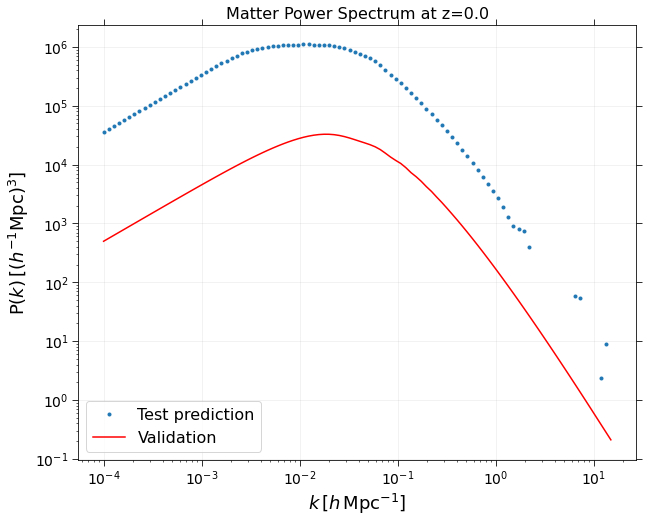

In [263]:
#Define func:

def calc_cosmo():
    input_cosmo_val = input(r'$H_{0}, \Omega_{b}, \Omega_{\mathrm{cdm}}$')
    print("\n")
    user_list = input_cosmo_val.split()
    # print list
    print('parameters: ', user_list)

    # convert each item to int type
    for i in range(len(user_list)):
        # convert each item to int type
        user_list[i] = float(user_list[i])
        
    
    
    
    cosmo_arr = np.reshape(np.array(user_list),(1, 3))
    pred_pk = tf_model.predict(cosmo_arr)
    
    def camb_cosmo2():
    
        #Compute P.S via CAMB:
        pars = camb.CAMBparams()
        pars.set_cosmology(H0=cosmo_arr[0][0], ombh2=cosmo_arr[0][1], omch2=cosmo_arr[0][2])
        pars.InitPower.set_params(As = 2e-9, ns=0.965)
        pars.set_matter_power(redshifts=[0.0], kmax=10.0)
        pars.set_dark_energy(w=-1.0, wa=0, dark_energy_model='fluid')

        # Linear spectra
        pars.NonLinear = model.NonLinear_none
        results = camb.get_results(pars)
        camb_kh, z, camb_pk = results.get_matter_power_spectrum(minkh=1e-4, maxkh=15, npoints=100)
        s8 = np.array(results.get_sigma8())
    
    
#         plt.figure(figsize = (10,8))
#         plt.loglog(camb_kh, camb_pk[0], 'r')
#         #plt.plot(, r_array, 'ro')
#         plt.title('Matter Power Spectrum at z=0.0')
#         plt.rc('axes', labelsize=18)
#         plt.rc('axes', titlesize=16)
#         plt.rcParams['xtick.labelsize']=14
#         plt.rcParams['ytick.labelsize']=14
#         plt.xlabel(r'$k\,[h\,\mathrm{Mpc}^{-1}]$')
#         plt.ylabel(r'$\mathrm{P}(k)\, [(h^{-1}\mathrm{Mpc})^{3}]$')
#         #plt.legend(['linear'], loc='lower left', fontsize=14);
#         plt.grid(alpha=0.2)
#         plt.tick_params(top=True,right=True, length=6)
#         plt.show()
    
        return camb_kh, camb_pk[0] 
    
    generate_camb_ps = camb_cosmo2()
    

    print('H0:', cosmo_arr[0][0], 'Omega_b:', cosmo_arr[0][1], 'Omega_c:', cosmo_arr[0][2])
    print(pred_pk)
    
    plt.figure(figsize = (10,8))                                             
    plt.loglog(generate_camb_ps[0], pred_pk[0], "C0.")                   # blue line: prediction
    #plt.loglog(X_test, y_test, "C1d")
    plt.loglog(generate_camb_ps[0], generate_camb_ps[1], 'r')            # : P.S computed by CAMB (original)  
    plt.title('Matter Power Spectrum at z=0.0')
    plt.rc('axes', labelsize=18)
    plt.rc('axes', titlesize=16)
    plt.rcParams['xtick.labelsize']=14
    plt.rcParams['ytick.labelsize']=14
    plt.xlabel(r'$k\,[h\,\mathrm{Mpc}^{-1}]$')
    plt.ylabel(r'$\mathrm{P}(k)\, [(h^{-1}\mathrm{Mpc})^{3}]$')
    plt.legend(['Test prediction','Validation', 'Training'], loc='lower left', fontsize=16);
    plt.grid(alpha=0.2)
    plt.tick_params(top=True,right=True, length=6)
    plt.show()
    
    

Generate = calc_cosmo()